# Chapter 1/2 - Python and Finance Interesting Snippets
Note: this part of the book is not meant to be followed. I decided to implement the code as an excercise/challenge!

## Basic Options Pricing
Implementing Black-Scholes-Merton for european options given by:

$$
S_T = S_0 \exp\left( \left( r - \frac{1}{2} \sigma^2 \right) T + \sigma \sqrt{T} z \right)
$$

where $z\sim N(0,1)$, $S_0$ is the initial stock price, $r$ is the risk-free rate, $\sigma$ is the volatility, $T$ is the time to maturity, and $K$ is the strike price.

In [12]:
from jax import vmap, grad
import jax.scipy as jsp
import jax.random as random
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [2]:
class parameters:
    def __init__(self, init_index=100.0, call_strike=105.0, maturity=1.0, short_rate=0.05, volatility=0.2, num_steps=10000):
        self.init_index = init_index
        self.call_strike = call_strike
        self.maturity = maturity
        self.short_rate = short_rate
        self.volatility = volatility
        self.num_steps = num_steps

params = parameters()

Generate a `params.num_steps` number of stock prices, each with a different random shock given by the Weiner process of picking `z` from a standard normal distribution.

In [3]:
key = random.PRNGKey(1)
z = random.normal(key, (params.num_steps,))

x = jnp.zeros(params.num_steps)
x = x.at[0].set(params.init_index)

for i in range(params.num_steps - 1):
    x_i1 = params.init_index*jnp.exp((params.short_rate -((1/2)*(params.volatility**2)))*params.maturity + params.volatility*jnp.sqrt(params.maturity)*z[i])
    x = x.at[i+1].set(x_i1)

In [4]:
h = lambda x: jnp.maximum(0, x - params.call_strike)
h = vmap(h)(x)

C_price = jnp.exp(-params.short_rate*params.maturity)*jnp.mean(h)
print(f"Value of the European Call Option: {C_price}")

Value of the European Call Option: 8.005196571350098


## Accessing Data from Web

In [5]:
import pandas as pd
from pandas_datareader import data
from datetime import date
import numpy as np

In [6]:
startdate = pd.to_datetime('2018-07-15')
enddate = pd.to_datetime(date.today())

goog = data.DataReader("GOOG", 'stooq', startdate, enddate)

Implementing Volatility through log-relative and rolling standard deviation.

$$
\begin{align*}
    u_i &= \ln\left(\frac{S_i}{S_{i-1}}\right)
    \\

    \\
    \sigma &= \sqrt{\frac{1}{n-1}\sum_{i=1}^{n} (u_i - \bar{u})^2}
\end{align*}
$$

Note that this is anual volatility so we we multiply by the square root of the number of trading days in a year, i.e. $\sqrt{252}$. We square root because it's a standard deviation and not variance.

In [7]:
goog['Log_Rel'] = np.log(goog['Close']/goog['Close'].shift(1))
goog['Volatility'] = goog['Log_Rel'].rolling(window=252).std()*np.sqrt(252)

In [8]:
goog

,Open,High,Low,Close,Volume,Log_Rel,Volatility
Date,,,,,,,
2024-10-03,165.8200,167.910,165.370,167.2100,11004333,NaN,NaN
2024-10-02,167.7600,168.880,166.250,167.3100,12744975,0.000598,NaN
2024-10-01,168.8600,170.440,165.900,168.4200,18629506,0.006612,NaN
2024-09-30,164.7800,167.360,164.640,167.1900,14083451,-0.007330,NaN
2024-09-27,163.9100,166.970,163.830,165.2900,13604261,-0.011429,NaN
...,...,...,...,...,...,...,...
2018-07-20,59.3480,59.843,59.211,59.2455,24968000,-0.017228,0.271138
2018-07-19,59.5500,60.000,59.166,59.3480,25533340,0.001729,0.271044
2018-07-18,59.8280,60.225,59.517,59.7940,27872120,0.007487,0.271046


array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>], dtype=object)

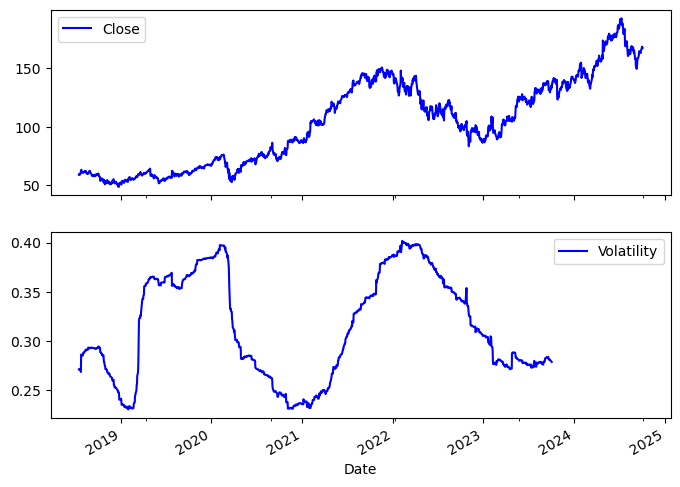

In [9]:
goog[['Close', 'Volatility']].plot(subplots=True, color='blue', figsize=(8, 6))

## Chapter 3 -- Introductory Examples
3 main concepts explored:

1. Implied Volatilities
2. Monte Carlo Simulations
3. Technical Analysis

### Implied Volatilities

Take the Black-Sholes Option Pricing model for example:

$$
C(S_t, K, t, T, r, \sigma) = S_T\cdot\mathbf{N}(d_1)-e^{-r(T-t)}\cdot K\cdot \mathbf{N}(d_2)
$$

Where $\mathbf{N} \sim \mathcal{N}(0,1)$ and $\mathbf{N}(d) = \mathbb{P}(x \leq d)$, and the other terms are equal to some "scary" looking terms.

Now suppose I've given you a quote $C^*$ for the european call option. Then the implied volatility is $\sigma^{\textrm{imp}}$ s.t. $C(S_t, K, t, T, r, \sigma^{\textrm{imp}}) = C^*$

There is no closed form solution so we have to use something like Newton's method to do root finding.(pretty basic stuff from Applied Numerical Methods 1/2)

The derivative w.r.t volatility is called the ***vega*** of a european option in BSM:

$$
\frac{\partial C}{\partial \sigma} = S_t\mathbf{N}^\prime(d_1)\sqrt{T-t}
$$

Now this is as simple as defining the equation and say using jax to autograd it through, that is if we're not worried about the amount of time taken. Good thing is we have plenty of years of financial research behind us!

In [15]:
def bsm_call_val(S0:float, K:float, T:float, r:float, sigma:float):
    d1 = (jnp.log(S0 / K) + (r + 0.5*sigma**2)*T) / (sigma * jnp.sqrt(T))
    d2 = (jnp.log(S0 / K) + (r - 0.5*sigma**2)*T) / (sigma * jnp.sqrt(T))
    value = (S0 - jsp.stats.norm.cdf(d1, 0.0, 1.0)) - K*jnp.exp(-r*T)*jsp.stats.norm.cdf(d2, 0.0, 1.0)
    return value

bsm_vega_autograd = grad(bsm_call_val, argnums=(4))

def bsm_vega_exact(S0:float, K:float, T:float, r:float, sigma:float):
    d1 = ((jnp.log(S0 / K) + (r + 0.5*sigma**2))*T) / (sigma * jnp.sqrt(T))
    vega = S0 * jsp.stats.norm.cdf(d1, 0.0, 1.0)*jnp.sqrt(T)
    return vega

def bsm_call_imp_vol(S0:float, K:float, T:float, r:float, C0:float, sigma_est:float, it=100):
    for i in range(it):
        sigma_est -= (bsm_call_val(S0, K, T, r, sigma_est) - C0)/(bsm_vega_exact(S0, K, T, r, sigma_est))
    return sigma_est

The book goes on to use data that I'm unable to find.